# Add Custom Task-Specific layers to Huggingface Transformer models
* Notebook by Adam Lang
* Date: 6/12/2024
* We will review the concepts and implementation of how to add custom task-specific layers to a huggingface model and transformers.

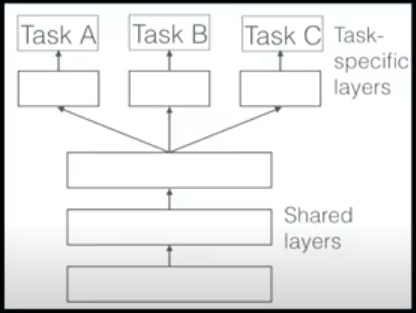

## What is this exactly?
* We take a base model "body" and add a task-specific "head".
* Switching from a pre-trained transformer to a task-specific model involves swapping out the last layer of the model for the task or tasks we need.
* The last layer of the model is called the **"HEAD"**
  * The "**HEAD**" is task-specific.
  * The "**BODY**" contains "task-agnostic" layers.
      * Tokens
      * Embeddings
      * Transformer layers

## How do we get the **HEAD** of the model?
* We need the last hidden state:
  * `outputs[0]`
* HF transformers provide different model heads for every transformer as long as a model supports a "task".
* This is why transformers are task specific models
* As an example:
  * You can't use **DistilBERT** for seq2seq task because it is not a seq2seq model.
* There are BERT specific seq2seq models
  * DistilBERT for sequence classification has a sequence classification head which is a linear layer on top of the hidden state output.
* DistilBERT for QA
  * Same idea --> linear layer on top of hidden state (last layer) output.

## Anatomy of a huggingface transformer
* This is a diagram from an article on Towards Data Science by Raj Sangani which is an awesome depiction of the "anatomy" of a huggingface transformer
* link to article: https://towardsdatascience.com/adding-custom-layers-on-top-of-a-hugging-face-model-f1ccdfc257bd

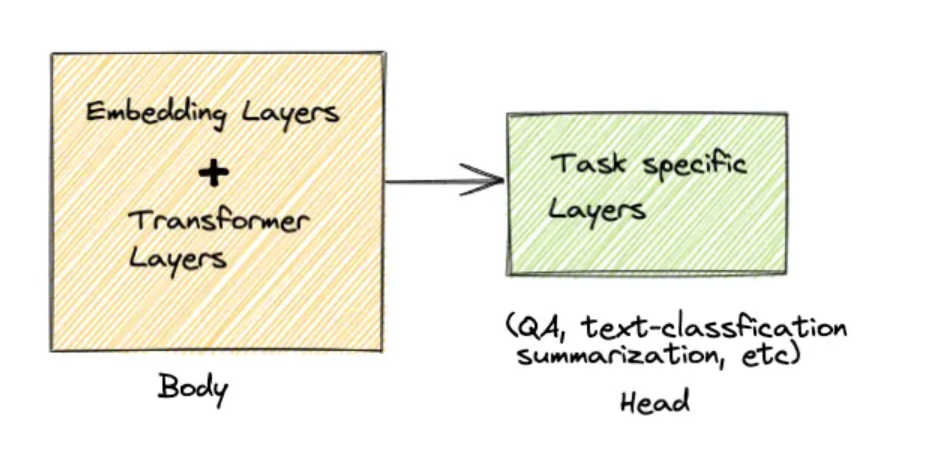

* We can see the "BODY" and the "HEAD".
  * The BODY has the pre-trained embedding and transformer layers.
  * The HEAD has the task the model has been pre-trained to perform such as:
    * classification
    * question/answer
    * summarization
    * entity recognition
    * text generation
    * etc....

## Fine-Tuning the "HEAD" of a Transformer
* These are 2 examples of what this entails, again taken from the excellent article mentioned above.
1. Example of changing a transformer HEAD from question-answering to text classification

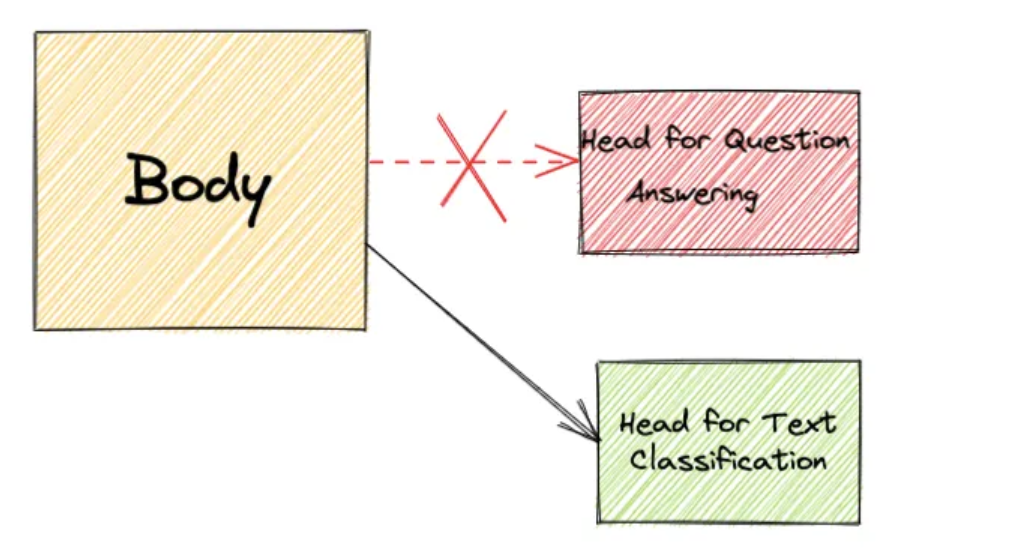


2. Example of changing a transformer HEAD from classification with 5 output layers to classification with 2 output layers:

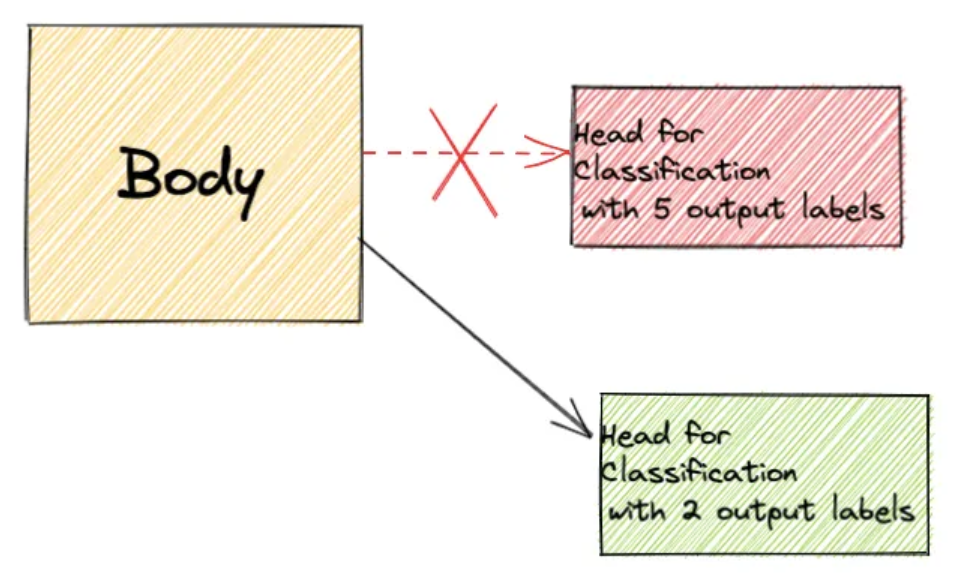

## Basic Workflow of how to fine-tune a Transformer from HuggingFace
* Image taken from same article mentioned above:

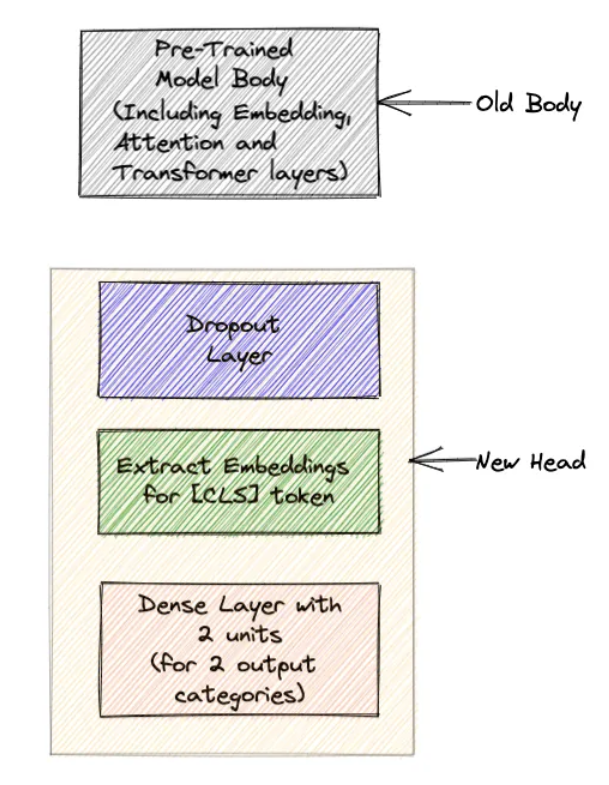

# Project Description
* We will use a dataset from Kaggle.
  * News Sarcasm detection dataset: https://www.kaggle.com/datasets/rmisra/news-headlines-dataset-for-sarcasm-detection
* We will use a DistilBERT-base-uncased model.
  * On top of this we will add a classification head (linear layer) on top of the last hidden layer.

### Imports

In [1]:
# install huggingface datasets
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.3 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 2

In [2]:
import numpy as np
import pandas as pd
# huggingface imports
from datasets import DatasetDict, load_dataset, Dataset
from transformers import (
    DataCollatorWithPadding,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    AutoTokenizer,
    AutoModel,
    AutoConfig
)
from transformers.modeling_outputs import TokenClassifierOutput

#pytorch imports
import torch
import torch.nn as nn



In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Dataset Path

In [4]:
dataset_v2_path = '/content/drive/MyDrive/Colab Notebooks/Deep Learning Notebooks/NLP_deep_learning/BERT_transformers/Sarcasm_Headlines_Dataset_v2.json'

## Load Dataset
* This is a JSON file we will load into a pandas dataframe.

In [5]:
df = pd.read_json(dataset_v2_path, lines=True)

#head of df
df.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


Summary
* For now we will ignore the `article_link` column as we are fine-tuning this model to predict on the `is_sarcastic` binary variable based on the text in the `headline` column.

Task
* Fine-tune DistilBERT-uncased transformer model (HEAD) to predict whether a text headline is sarcastic or not.

## Load Dataset with HuggingFace `load_datset`

In [6]:
dataset_hf = load_dataset("json", data_files=dataset_v2_path)


Generating train split: 0 examples [00:00, ? examples/s]

## Pre-Processing Dataset

In [7]:
## remove 'article_link' column - we don't need it
dataset_hf = dataset_hf.remove_columns(['article_link'])

## set format as 'pandas'
dataset_hf.set_format('pandas')

## setup train column
dataset_hf = dataset_hf['train'][:]



Note:
* All huggingface datasets are pre-split into train, test, and validation sets.
* Therefore we had to define the splits in our pandas dataframe.

In [8]:
print(type(dataset_hf))

<class 'pandas.core.frame.DataFrame'>


In [9]:
# print columns
print(dataset_hf.columns)

Index(['is_sarcastic', 'headline'], dtype='object')


In [10]:
## drop duplicates
dataset_hf.drop_duplicates(subset=['headline'],inplace=True)

# rename 'is_sarcastic' column as 'label'
dataset_hf = dataset_hf.rename(columns={'is_sarcastic':'label'})

## reset_index
dataset_hf=dataset_hf.reset_index()[['headline','label']]

## set as hf dataset
dataset_hf=Dataset.from_pandas(dataset_hf)

In [11]:
dataset_hf

Dataset({
    features: ['headline', 'label'],
    num_rows: 28503
})

In [12]:
## set train_test_split - 80% will be training data
train_testvalid = dataset_hf.train_test_split(test_size=0.2,seed=15)

# dividing data into test and validation sets 50/50 split
test_valid = train_testvalid['test'].train_test_split(test_size=0.5,seed=15)


# set DatasetDict - huggingface data format is a DatasetDict
dataset_hf = DatasetDict({
    'train': train_testvalid['train'], #train from train_testvalid - 80% of dataset
    'test': test_valid['test'],
    'valid': test_valid['train']}) #test_valid is 20% of orig dataset -- 10% valididation data


# output dataset_hf
dataset_hf

DatasetDict({
    train: Dataset({
        features: ['headline', 'label'],
        num_rows: 22802
    })
    test: Dataset({
        features: ['headline', 'label'],
        num_rows: 2851
    })
    valid: Dataset({
        features: ['headline', 'label'],
        num_rows: 2850
    })
})

In [13]:
# load model -- checkpoint is the original model path in HuggingFace
checkpoint = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
tokenizer.model_max_len=512

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

# Vector size "distilbert-base-uncased"
* `distilbert-base-uncased` model has each token embedded into a vector size of 768.
* The output shapes of the base model are always:
  * `(batch_size, max_sequence_length=512, embedding_vector_size=768)`

## Step 1: Tokenize a batch of the data

In [14]:
# function to tokenize batch of the data
def tokenize(batch):
  """This function takes in a batch of data and tokenizes it."""
  return tokenizer(batch['headline'], truncation=True, max_length=512)



## use function to build tokenized_dataset - hf .map method
tokenized_dataset = dataset_hf.map(tokenize, batched=True)
tokenized_dataset

Map:   0%|          | 0/22802 [00:00<?, ? examples/s]

Map:   0%|          | 0/2851 [00:00<?, ? examples/s]

Map:   0%|          | 0/2850 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['headline', 'label', 'input_ids', 'attention_mask'],
        num_rows: 22802
    })
    test: Dataset({
        features: ['headline', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2851
    })
    valid: Dataset({
        features: ['headline', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2850
    })
})

Summary of Tokenization
* We now have 2 new columns
1. input_ids
2. attention_mask

* As with any BERT based model, these to columns are what we will use for input to the model for it to be able to predict the output.

## Step 2: Collator + PyTorch workflow
1. `DataCollatorWithPadding` is a class in Hugging Face Transformers that helps in preparing batches of data for training transformer models.Specifically, it is designed to handle cases where **input sequences have different lengths** by dynamically padding them within a batch.

2. When training a transformer model, it is common to **batch sequences together for more efficient processing**. However, since sequences might be of different lengths, they often need to be **padded to a common length within each batch.**
3. The `DataCollatorWithPadding` class automates this process of padding batch sequences.

#### How the Collator Works
1. `Initialization:` Create an instance of DataCollatorWithPadding, typically specifying the tokenizer to be used and any other relevant parameters.
2. `Batch Preparation:` When you are preparing batches of data for training, you pass your list of examples to the data_collator instance.


Source: https://medium.com/@sujathamudadla1213/what-is-datacollatorwithpadding-in-hugging-face-transformers-12c2b3b2f612

In [15]:
tokenized_dataset.set_format('torch', columns=['input_ids','attention_mask','label'])


## define data_collator for padding batch sequences
## automatically pads each batch to length of longest text sequence
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

## Step 3: Custom PyTorch Neural Network Model Class
* This class you will tailor to the type of task specific fine tuning you want to perform to the HEAD of the transformer.
* #### Note about hidden layers
* In the neural network, the `self.hidden = nn.Linear(784, 256)` defines a **hidden fully connected layer** - what does this mean?
  * hidden means it is between input and output layers
* Takes input `x` of shape `(batch_size, 784)`
  * `batch_size` is number of inputs (each size 784) which are passed to the neural network at one time as a **single tensor**
  * Then transformed by the linear equation we all know:
      * `y = x*W^T + b`
      * into tensor `y` of shape `(batch_Size, 256)`

In [16]:
## define custom torch dataset class -
## We will use the model's BODY only, we will change the head
class MyTaskSpecificCustomModel(nn.Module):
  def __init__(self, checkpoint, num_labels):
    super(MyTaskSpecificCustomModel, self).__init__()
    self.num_labels = num_labels

    ## load DistilBERT model and extract BODY
    ## 'checkpoint' is the name of original model path from HuggingFace
    self.model = model = AutoModel.from_pretrained(checkpoint, config= AutoConfig.from_pretrained(checkpoint,
                                                                                                  output_attention=True,
                                                                                                  output_hidden_state=True))
    ### New_layer - Task-specific HEAD of transformer
    self.dropouts = nn.Dropout(0.1)
    self.classifier = nn.Linear(768, num_labels) # (input, output features)

  # forward function
  def forward(self, input_ids = None, attention_mask=None, labels=None):
    # first extract outputs from BODY of base model (DistilBERT)
    outputs = self.model(input_ids = input_ids, attention_mask = attention_mask)

    # custom task-specific HEAD - get last hidden state
    last_hidden_state = outputs[0]

    sequence_outputs = self.dropouts(last_hidden_state)

    # get logits (raw outputs)
    logits = self.classifier(sequence_outputs[:,0,:].view(-1, 768)) # first dim inferred, last is 768

    # calculate losses - binary classification
    loss = None
    if labels is not None:
      loss_func = nn.CrossEntropyLoss()
      loss = loss_func(logits.view(-1, self.num_labels), labels.view(-1))

    return TokenClassifierOutput(loss = loss, logits = logits, hidden_states=outputs.hidden_states, attentions = outputs.attentions)


## Step 4: Create PyTorch DataLoader

In [30]:
from torch.utils.data import DataLoader

# Train DataLoader
train_dataloader = DataLoader(
    tokenized_dataset['train'], shuffle = True, batch_size = 32, collate_fn = data_collator
)

# Validation DataLoader
eval_dataloader = DataLoader(
    tokenized_dataset['valid'], shuffle=False, collate_fn=data_collator #No batch_size - only for validation
)

## Setup Optimizer and get_scheduler

In [31]:
# setup device agnostic code
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## create model instance - 2 labels (binary classification) --> send to device
model_task_specific = MyTaskSpecificCustomModel(checkpoint=checkpoint,num_labels=2).to(device)



/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [32]:
from transformers import AdamW, get_scheduler

# define optimizer -->pass it the model --> set params + learning_rate
optimizer = AdamW(model_task_specific.parameters(),lr=5e-5)

#num_epochs
num_epoch = 3

# num training steps = epoch*len(train_dataloader)
num_training_steps = num_epoch * len(train_dataloader)

# learning rate scheduler
lr_scheduler = get_scheduler(
    'linear',
    optimizer = optimizer,
    num_warmup_steps = 0, #do not need warmup step
    num_training_steps = num_training_steps

)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


## Evaluation Metric: f1 score

In [33]:
## setup evaluation metric - F1 score
from datasets import load_metric
metric = load_metric("f1", trust_remote_code =True)

# Train the model

In [34]:
## first set up tqdm progres bars
from tqdm.auto import tqdm

progress_bar_train = tqdm(range(num_training_steps))
progress_bar_eval = tqdm(range(num_epoch * len(eval_dataloader)))


## training loop
for epoch in range(num_epoch):
  print("Epoch: ", (epoch + 1))
  # 1. Train block starts!
  model_task_specific.train()
  # 2. do the forward pass
  for batch in train_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    outputs = model_task_specific(**batch)
  # 3. calculate the loss
    loss = outputs.loss
  # 4. backward propagate
    loss.backward()
  # 5. optimizer step
    optimizer.step()
    lr_scheduler.step()

  # 6. zero the gradients
    optimizer.zero_grad()
  # 7. update progress bar
    progress_bar_train.update(1)


  ### Evaluation loop
  model_task_specific.eval()
  for batch in eval_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    # define context manager -- no gradient calculations
    with torch.no_grad():
      outputs = model_task_specific(**batch)

    # raw model outputs
    logits = outputs.logits
    ## argmax --> max probabilities of raw logits of last dim (-1)
    predictions = torch.argmax(logits, dim = -1)

    # metrics for evaluation - batch by batch calculation
    ## use add_batch method
    metric.add_batch(predictions = predictions, references= batch['labels'])
    progress_bar_eval.update(1)
# print the metrics
print(metric.compute())


  0%|          | 0/2139 [00:00<?, ?it/s]

  0%|          | 0/8550 [00:00<?, ?it/s]

Epoch:  1
Epoch:  2
Epoch:  3
{'f1': 0.9233716475095786}


# Post-Training Model Evaluation

In [35]:
model_task_specific.eval()

# get test dataloader
test_dataloader = DataLoader(
    tokenized_dataset['test'], batch_size = 32, collate_fn = data_collator)

## similar to training loader
for batch in test_dataloader:
  batch = {k: v.to(device) for k, v in batch.items()}
  ## define context manager - no gradient calculations
  with torch.no_grad():
    outputs = model_task_specific(**batch)

  ## get logits ==> predictions
  logits = outputs.logits
  predictions = torch.argmax(logits, dim = -1) # last dimension

  # metric calculation
  metric.add_batch(predictions = predictions, references = batch['labels'])

# print final metrics
print(metric.compute())

{'f1': 0.9212980231256993}


# Summary of Model Train and Test
* The F1 score for training on the new HEAD model architecture was 0.9228.
* The F1 score for the test data was 0.92129 so almost the same but a bit lower. We can say that the model we built did well on the evaluation data, however we could also look at finetuning some of the hyperparameters because the f1 score was virtually similar perhaps suggesting that the model maybe "memorized" the training data and could be close to overfitting.
  * We could change the optimizer that we used from AdamW to SGD.
  * We could change the learning rate and dropout.
  * We could train the model for more epochs.
* Either way, an F1 score of 92% for train and test is not bad considering this is the harmonic mean of precision and recall. Thus in summary, I would then consider using this model for classification tasks on this dataset or similar.